# Find an appropriate intensity threshold

Some cells are completely saturated with no localization pattern visible. Our hypothesis is that these are either particularly short or tall cells where the confocal plane is hitting where the cell is attaching to the well bottom. We wish to filter these out so that we are using mainly localization patterns to drive clustering. The number of super bright cells is different across different wells, so we will have to use flexible & robust statistics. 

Will use MedianIntensity as a robust measure of cell-wide intensity. Spot-checking specific alleles shows that some indeed exhibit a super long right tail - we think these are the cells that we want to filter out, but should make some plots to confirm. Not all distributions have high right skew .. perhaps the more symmetric distributions are proteins that localize to the nucleus? 

From some trial and error, an appropriate threshold seems to be +/- 5 MAD from the median of the Cells_MedianIntensity_GFP column (un-normalized/scaled).

In [1]:
# Imports
import polars as pl

In [2]:
# Paths
prof_path = "/dgx1nas1/storage/data/jess/repos/2021_09_01_VarChAMP/6.downstream_analysis_snakemake/outputs/batch_profiles/2024_01_23_Batch_7/profiles.parquet"

In [3]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, xlab, scale_x_log10, geom_vline

def gfpDistribution(dat: pl.DataFrame, gene_allele: str, plate: str = "all", well: str = "all", var = "Cells_Intensity_MedianIntensity_GFP"):
    dat = dat.filter(pl.col("Metadata_gene_allele") == gene_allele)

    median = dat.select(var).median().item()
    mad = dat.with_columns(
        (pl.col(var) - median).abs().alias("abs_deviation")
    ).select("abs_deviation").median().item()

    if plate != "all":
        dat = dat.filter(pl.col("Metadata_Plate") == plate)
    
    if well != "all":
        dat = dat.filter(pl.col("Metadata_well_position") == well)

    plot1 = (ggplot(dat) 
        + aes(x = var)
        + geom_histogram(bins=50)
        + geom_vline(xintercept = median, color = "blue")
        + geom_vline(xintercept = median + 5*mad, color = "red")
        + theme_bw()
        + scale_x_log10()
        + xlab("Median protein intensity (cell-level)"))

    plot1.show()

In [4]:
# Get metadata
profiles = pl.scan_parquet(prof_path).select(
    ['Metadata_well_position', 'Metadata_plate_map_name', 'Metadata_ImageNumber', 'Metadata_ObjectNumber', 'Metadata_symbol', 'Metadata_gene_allele', 'Metadata_control_type', 'Metadata_Plate', 
    'Nuclei_AreaShape_Area', 'Cells_AreaShape_Area', 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y', 'Cells_Intensity_MedianIntensity_GFP', 'Cells_Intensity_IntegratedIntensity_GFP']
).collect()
profiles.shape

(1866461, 14)

In [5]:
# Filter based on cell to nucleus area
profiles = profiles.with_columns(
                (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area"),
                pl.concat_str(['Metadata_Plate', 'Metadata_well_position', 'Metadata_ImageNumber', 'Metadata_ObjectNumber'], separator="_").alias("Metadata_CellID")
        ).filter((pl.col("Nucleus_Cell_Area") > 0.15) & (pl.col("Nucleus_Cell_Area") < 0.3))
profiles.shape

(1256972, 16)

In [6]:
# Filter cells too close to image edge
profiles = profiles.filter(
    (pl.col("Nuclei_AreaShape_Center_X") > 50) & (pl.col("Nuclei_AreaShape_Center_X") < 1030) & (pl.col("Nuclei_AreaShape_Center_Y") > 50) & (pl.col("Nuclei_AreaShape_Center_Y") < 1030)
)
profiles.shape

(1122944, 16)

In [7]:
# Calculate median and mad of gfp intensity for each allele
medians = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
    pl.col("Cells_Intensity_MedianIntensity_GFP").median().alias("WellIntensityMedian")
)

profiles = profiles.join(medians, on=["Metadata_Plate", "Metadata_well_position"])

profiles = profiles.with_columns(
    (pl.col("Cells_Intensity_MedianIntensity_GFP") - pl.col("WellIntensityMedian")).abs().alias("Abs_dev")
)
mad = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
    pl.col("Abs_dev").median().alias("Intensity_MAD")
)
profiles = profiles.join(mad, on=["Metadata_Plate", "Metadata_well_position"])

# Threshold is 5X
profiles = profiles.with_columns(
    (pl.col("WellIntensityMedian") + 5*pl.col("Intensity_MAD")).alias("Intensity_upper_threshold"),
    (pl.col("WellIntensityMedian") - 5*pl.col("Intensity_MAD")).alias("Intensity_lower_threshold")
)

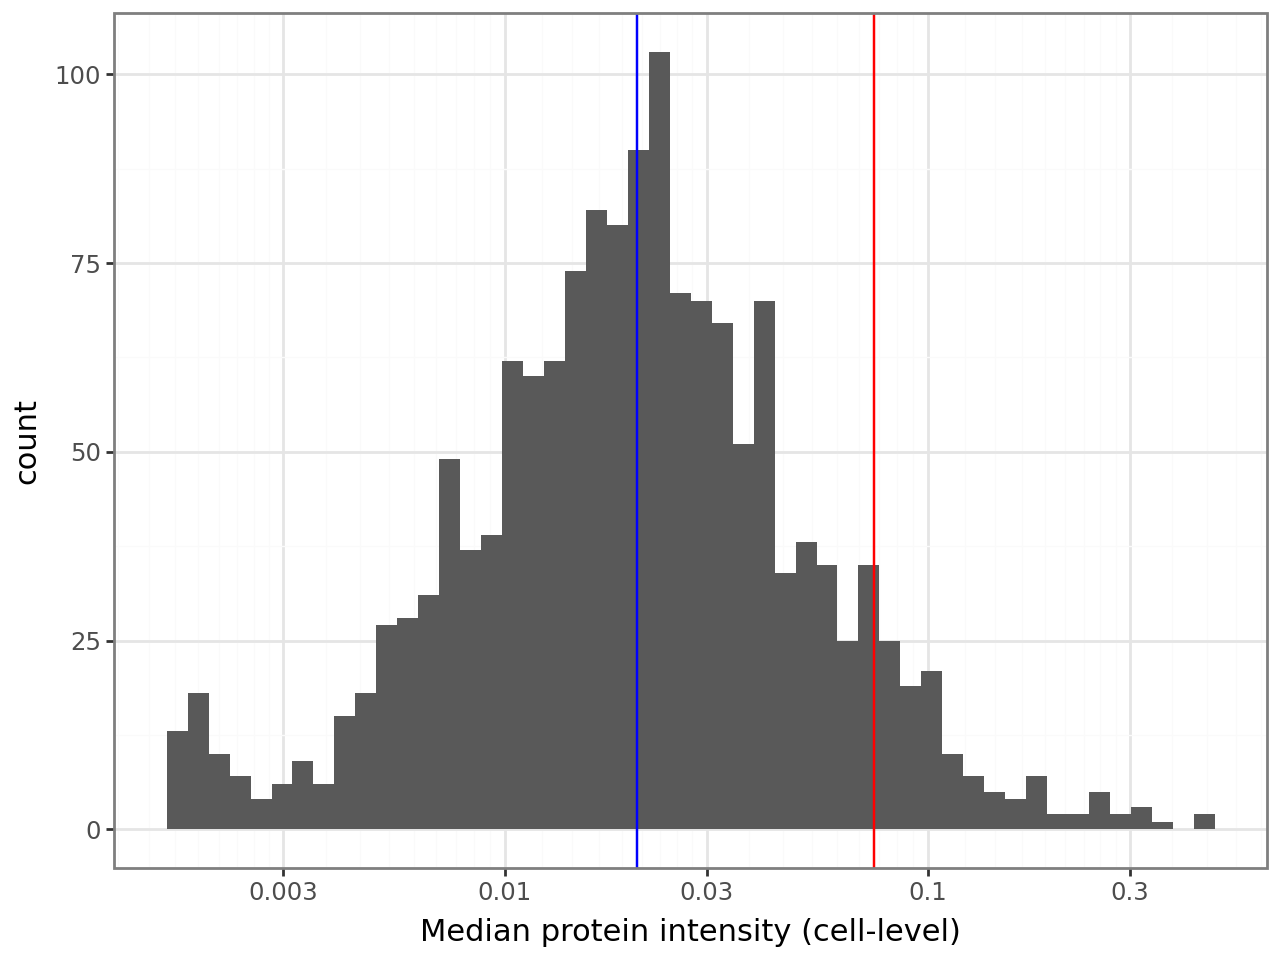

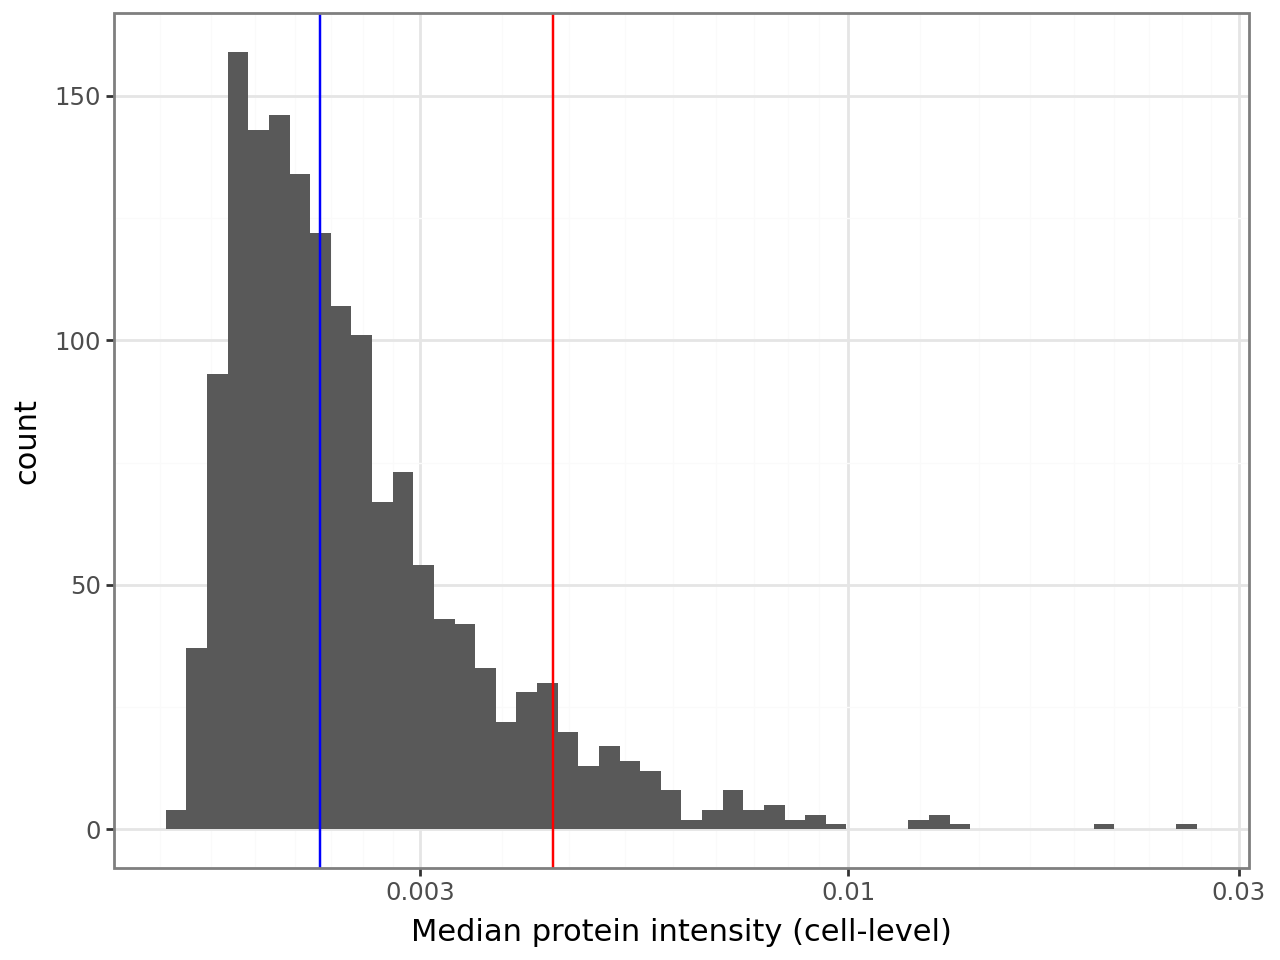

In [8]:
gfpDistribution(profiles, "FBP1")
gfpDistribution(profiles, "MLH1_Ile36Asn")